- 라이브러리 로딩

In [222]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

## 데이터 셋

In [223]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_file="data/SBUX.csv", seq_length=10, train_ratio=0.8, is_train=True):
        self.seq_length = seq_length
        self.is_train = is_train

        df = pd.read_csv(csv_file)
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
        df = self._add_techinical_indicators(df)
        
        features_cols = ["Close", "Volume", "MA_5", "MA_20", "RSI", "Volatility", "Price_Change", "Volume_MA"]

        data = df[features_cols].values

        # 결측값 처리
        data_df = pd.DataFrame(data)
        data = data_df.ffill().bfill().values

        # 추가된 특성을 사용

        self.scaler = RobustScaler()
        scaled_data = self.scaler.fit_transform(data)

        X, y = self._create_sequences(scaled_data, seq_length)

        train_size = int(len(X) * train_ratio)

        if self.is_train:
            self.X = torch.FloatTensor(X[:train_size])
            self.y = torch.FloatTensor(y[:train_size])
            self.dates = df['Date'].iloc[seq_length : train_size + seq_length]
        else:
            self.X = torch.FloatTensor(X[train_size:])
            self.y = torch.FloatTensor(y[train_size:])
            self.dates = df['Date'].iloc[train_size + seq_length :]

    def _create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def _add_techinical_indicators(self, df):
        # 이동 평균
        df["MA_5"] = df["Close"].rolling(window=5).mean() # 5일차
        df["MA_20"] = df["Close"].rolling(window=20).mean()

        # RSI
        delta = df["Close"].diff()
        gain = delta.where(delta > 0, 0).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        # 변동성
        df["Volatility"] = df["Close"].rolling(window=14).std()

        # 가격변화율
        df["Price_Change"] = df["Close"].pct_change()

        # 거래량 이동평균
        df["Volume_MA"] = df["Volume"].rolling(window=10).mean()
        return df

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [224]:
seq_length = 10
batch_size = 16

train_dataset = TimeSeriesDataset(seq_length=seq_length, is_train=True)
test_dataset = TimeSeriesDataset(seq_length=seq_length, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 학습모델

> hidden_size 중요

### RNN

In [ ]:
# class RNNModel(nn.Module):
#     # 연속 데이터의 시간/순서 종속성을 기반으로 학습 가능 (장점)
#     # 장기 의존성/병렬처리가 안 됨 (단점) // 장기 의존성 : 기울기 사라짐 (필터의 시작에서 멀어질 수록 시작 값의 영향력이 줄어서 희미해짐)
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNNModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.rnn_cell = nn.RNNCell(input_size, hidden_size) # 히든레이어는 진짜 내가 정하는 거, 정해진 거 없음
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x): # 오리지널 버전 (반복문은 쿠다에 못 올라감)
#         batch_size = x.size(0)
#         h_t = torch.zeros(batch_size, self.hidden_size).to(x.device) # 초기화

#         for t in range(x.size(1)):
#             h_t = self.rnn_cell(x[:, t, :], h_t) # 앞에 있는 애로부터 차츰차츰 하는 방식 (CNN은 한번에 함)
        
#         output = self.fc(h_t)
#         return output

RNN, LSTM 컨셉 알고 있어야 함 (많이 물어봄)

### LSTM

In [226]:
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
#         self.fc = nn.Linear(hidden_size, output_size)
#     def forward(self, x):
#         batch_size = x.size(0)
#         h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
#         c_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
#         for t in range(x.size(1)):
#             h_t, c_t = self.lstm_cell(x[:, t, :], (h_t, c_t))
#         output = self.fc(h_t)
#         return output

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True) # lstm: 이미 안에 셀이 있다고 생각, 안에서 반복문처리해서 값을 내줌 (lstm_cell이 아닌 이유)
        self.fc = nn.Linear(hidden_size, output_size)                  # batch_first=True: true로 해야 배치가 처음으로 됨 / false => (seq, batch, feature)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x) # output, (h_n, c_n)
        return self.fc(h_n.squeeze(0)) # .squeeze(0) : 차원 맞춰줌...

### GRU

In [227]:
# class GRUModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(GRUModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.gru_cell = nn.GRUCell(input_size, hidden_size) 
#         self.fc = nn.Linear(hidden_size, output_size)
#     def forward(self, x):
#         batch_size = x.size(0)
#         h_t = torch.zeros(batch_size, self.hidden_size).to(x.device)
#         for t in range(x.size(1)):
#             h_t = self.gru_cell(x[:, t, :], h_t)
#         output = self.fc(h_t)
#         return output

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, h_n = self.gru(x)
        return self.fc(h_n.squeeze(0))

### 양방향LSTM

In [228]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm_cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size) # hidden_size*2 : 이전 셀, 이후 셀

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        _, (h_n, _) = self.bilstm_cell(x, (h_0, c_0))
        last_hidden_state = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)

        output = self.fc(last_hidden_state)
        return output

## 모델 학습

In [229]:
input_size = 8
hidden_size = 50
output_size = 1
num_epochs = 100
learning_rate = 0.001
num_layers_bilstm = 2

In [ ]:
rnn_model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    rnn_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = rnn_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'RNN Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

rnn_model.eval()
rnn_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = rnn_model(batch_X)
        rnn_test_predictions.append(outputs.cpu().numpy()) # cpu꺼 다 들고와서

rnn_test_predictions = np.concatenate(rnn_test_predictions) # 배열합치기
rnn_test_predictions_rescaled = train_dataset.scaler.inverse_transform(rnn_test_predictions)
y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

In [231]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    lstm_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

lstm_model.eval()
lstm_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = lstm_model(batch_X)
        lstm_test_predictions.append(outputs.cpu().numpy()) # cpu꺼 다 들고와서

lstm_test_predictions = np.concatenate(lstm_test_predictions) # 배열합치기
lstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(lstm_test_predictions)
y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

C:\Users\user\AppData\Local\Programs\Python\Python39\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([16, 8])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\user\AppData\Local\Programs\Python\Python39\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2, 8])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LSTM Epoch [10/100], Loss: 0.1215
LSTM Epoch [20/100], Loss: 0.2049
LSTM Epoch [30/100], Loss: 0.2757
LSTM Epoch [40/100], Loss: 0.6455
LSTM Epoch [50/100], Loss: 0.2021
LSTM Epoch [60/100], Loss: 0.6029
LSTM Epoch [70/100], Loss: 0.1572
LSTM Epoch [80/100], Loss: 1.3491
LSTM Epoch [90/100], Loss: 0.1239
LSTM Epoch [100/100], Loss: 0.5952


ValueError: non-broadcastable output operand with shape (49,1) doesn't match the broadcast shape (49,8)

In [ ]:
# gru_model = GRUModel(input_size, hidden_size, output_size)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     gru_model.train()
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = gru_model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch+1) % 10 == 0:
#         print(f'GRU Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# gru_model.eval()
# gru_test_predictions = []
# with torch.no_grad():
#     for batch_X, batch_y in test_loader:
#         outputs = gru_model(batch_X)
#         gru_test_predictions.append(outputs.cpu().numpy()) # cpu꺼 다 들고와서

# gru_test_predictions = np.concatenate(gru_test_predictions) # 배열합치기
# gru_test_predictions_rescaled = train_dataset.scaler.inverse_transform(gru_test_predictions)
# y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

GRU Epoch [10/100], Loss: 0.0038
GRU Epoch [20/100], Loss: 0.0002
GRU Epoch [30/100], Loss: 0.0008
GRU Epoch [40/100], Loss: 0.0035
GRU Epoch [50/100], Loss: 0.0000
GRU Epoch [60/100], Loss: 0.0036
GRU Epoch [70/100], Loss: 0.0030
GRU Epoch [80/100], Loss: 0.0023
GRU Epoch [90/100], Loss: 0.0006
GRU Epoch [100/100], Loss: 0.0031


In [ ]:
# bilstm_model = BiLSTMModel(input_size, hidden_size, num_layers_bilstm, output_size)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     bilstm_model.train()
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = bilstm_model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
    
#     if (epoch+1) % 10 == 0:
#         print(f'BiLSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# bilstm_model.eval()
# bilstm_test_predictions = []
# with torch.no_grad():
#     for batch_X, batch_y in test_loader:
#         outputs = bilstm_model(batch_X)
#         bilstm_test_predictions.append(outputs.cpu().numpy())

# bilstm_test_predictions = np.concatenate(bilstm_test_predictions)
# bilstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(bilstm_test_predictions)
# y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

BiLSTM Epoch [10/100], Loss: 0.0023
BiLSTM Epoch [20/100], Loss: 0.0196
BiLSTM Epoch [30/100], Loss: 0.0021
BiLSTM Epoch [40/100], Loss: 0.0007
BiLSTM Epoch [50/100], Loss: 0.0137
BiLSTM Epoch [60/100], Loss: 0.0056
BiLSTM Epoch [70/100], Loss: 0.0005
BiLSTM Epoch [80/100], Loss: 0.0030
BiLSTM Epoch [90/100], Loss: 0.0021
BiLSTM Epoch [100/100], Loss: 0.0029


## 평가 시각화

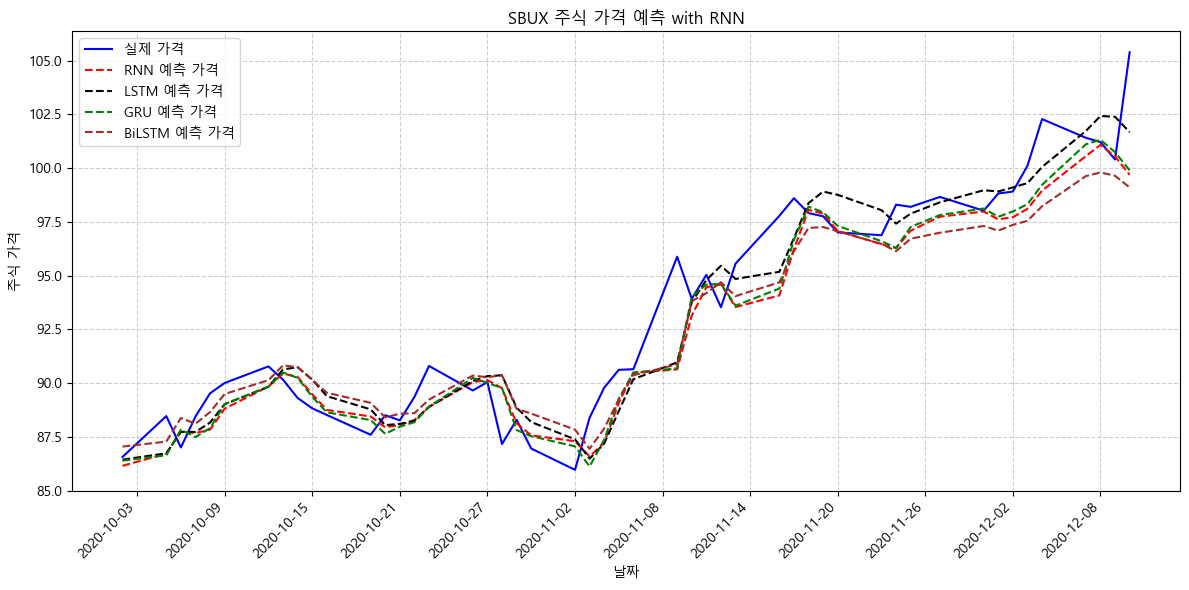

In [ ]:

plt.plot(test_dataset.dates, y_test_rescaled, label='실제 가격', color='blue')
# plt.plot(test_dataset.dates, rnn_test_predictions_rescaled, label='RNN 예측 가격', color='red', linestyle='--')
plt.plot(test_dataset.dates, lstm_test_predictions_rescaled, label='LSTM 예측 가격', color='black', linestyle='--')
# plt.plot(test_dataset.dates, gru_test_predictions_rescaled, label='GRU 예측 가격', color='green', linestyle='--')
# plt.plot(test_dataset.dates, bilstm_test_predictions_rescaled, label='BiLSTM 예측 가격', color='brown', linestyle='--')
plt.xlabel('날짜')
plt.ylabel('주식 가격')
plt.title('SBUX 주식 가격 예측 with RNN')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15)) # x축 눈금 개수를 최대 15개로 자동 조정
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:

# rnn_mse = np.mean((y_test_rescaled - rnn_test_predictions_rescaled)**2)
lstm_mse = np.mean((y_test_rescaled - lstm_test_predictions_rescaled)**2)
# gru_mse = np.mean((y_test_rescaled - gru_test_predictions_rescaled)**2)
# bilstm_mse = np.mean((y_test_rescaled - bilstm_test_predictions_rescaled)**2)

# print(f'RNN 모델 테스트 MSE (원래 스케일): {rnn_mse:.4f}')
print(f'LSMT 모델 테스트 MSE (원래 스케일): {lstm_mse:.4f}')
# print(f'GRU 모델 테스트 MSE (원래 스케일): {gru_mse:.4f}')
# print(f'BiLSTM 모델 테스트 MSE (원래 스케일): {bilstm_mse:.4f}')

RNN 모델 테스트 MSE (원래 스케일): 3.0312
LSMT 모델 테스트 MSE (원래 스케일): 2.4318
GRU 모델 테스트 MSE (원래 스케일): 2.7933
BiLSTM 모델 테스트 MSE (원래 스케일): 3.4740
